# Performance Analysis with Alphalens

## Imports & Settings

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os

# Get the current working directory
path = os.getcwd()

# Print the path
print("Current Path:", path)

# 이동할 디렉토리 경로
path = '/content/drive/MyDrive/Colab Notebooks'

# 디렉토리 변경
os.chdir(path)

Current Path: /content


In [44]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [46]:
sns.set_style('whitegrid')

In [47]:
np.random.seed(42)
idx = pd.IndexSlice

In [58]:
results_path = Path('KR2_results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Alphalens Analysis

### Load predictions

In [59]:
DATA_STORE = Path(results_path / 'data.h5')

In [60]:
predictions = pd.read_hdf(results_path / 'predictions.h5', 'predictions')

In [74]:
predictions

50        51        52        53        54  \
date       ticker                                                        
2018-05-25 000020.KS  0.040641  0.081166  0.097349  0.098991  0.119275   
           000040.KS  0.092641  0.104553  0.120835  0.118723  0.125409   
           000050.KS  0.101895  0.143689  0.120337  0.130517  0.143669   
           000070.KS  0.083896  0.104633  0.122944  0.110993  0.121802   
           000075.KS  0.114436  0.121420  0.125571  0.125743  0.126555   
...                        ...       ...       ...       ...       ...   
2023-05-12 451800.KS  0.043185  0.040875  0.023914  0.028295  0.021827   
           452260.KS  0.032751  0.029912  0.019208  0.024241  0.024190   
           453340.KS  0.024177  0.026142  0.020134  0.024196  0.021928   
           900140.KS  0.040498  0.032382  0.014603  0.017197  0.011275   
           950210.KS -0.013945  0.003388 -0.002909 -0.000422 -0.013596   

                            55        56        57        58        59  ...  \
date       ticker                                                       ...   
2018-05-25 000020.KS  0.118682  0.115823  0.138521  0.128921  0.119598  ...   
           000040.KS  0.124329  0.126815  0.148523  0.132446  0.121560  ...   
           000050.KS  0.150319  0.117780  0.141134  0.126851  0.107337  ...   
           000070.KS  0.116582  0.124479  0.143900  0.131539  0.122675  ...   
           000075.KS  0.131347  0.118277  0.142389  0.130253  0.119357  ...   
...                        ...       ...       ...       ...       ...  ...   
2023-05-12 451800.KS  0.017456  0.022532  0.025019  0.030964  0.040930  ...   
           452260.KS  0.023607  0.026725  0.030483  0.037750  0.048165  ...   
           453340.KS  0.024761  0.031764  0.042945  0.065138  0.075654  ...   
           900140.KS  0.009519  0.009810  0.012886  0.009735  0.016366  ...   
           950210.KS -0.015738 -0.011282 -0.011584 -0.014105 -0.008136  ...   

                            70        71        72        73        74  \
date       ticker                                                        
2018-05-25 000020.KS  0.166055  0.167745  0.167015  0.172683  0.161027   
           000040.KS  0.160247  0.153608  0.148865  0.153466  0.153959   
           000050.KS  0.147569  0.143726  0.139907  0.145353  0.146795   
           000070.KS  0.166656  0.162356  0.159780  0.166870  0.158356   
           000075.KS  0.155218  0.153405  0.151002  0.158347  0.156245   
...                        ...       ...       ...       ...       ...   
2023-05-12 451800.KS  0.066590  0.070182  0.077850  0.063280  0.064770   
           452260.KS  0.057060  0.061336  0.069746  0.058287  0.059121   
           453340.KS  0.086080  0.087899  0.091441  0.074112  0.077464   
           900140.KS  0.026200  0.029312  0.028507  0.029512  0.033366   
           950210.KS  0.010118  0.015144  0.021265  0.027270  0.029878   

                            75        76        77        78        79  
date       ticker                                                       
2018-05-25 000020.KS  0.170037  0.165164  0.162555  0.175062  0.163776  
           000040.KS  0.152358  0.148719  0.156427  0.162235  0.153175  
           000050.KS  0.143260  0.139743  0.146252  0.149947  0.141103  
           000070.KS  0.165013  0.160635  0.161776  0.172344  0.161516  
           000075.KS  0.154041  0.151334  0.154143  0.161630  0.151395  
...                        ...       ...       ...       ...       ...  
2023-05-12 451800.KS  0.065536  0.065173  0.069061  0.071161  0.077495  
           452260.KS  0.059042  0.059423  0.067136  0.064378  0.072080  
           453340.KS  0.093499  0.080278  0.079729  0.091098  0.089868  
           900140.KS  0.034181  0.034423  0.043177  0.038895  0.042410  
           950210.KS  0.028687  0.031764  0.041370  0.034814  0.038642  

[223080 rows x 30 columns]

In [61]:
factor = (predictions.mean(axis=1)
          .unstack('ticker')
          .resample('W-FRI', level='date')
          .last()
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())
tickers = factor.index.get_level_values('ticker').unique()

In [77]:
tickers

Index(['000020.KS', '000040.KS', '000050.KS', '000070.KS', '000075.KS',
       '000087.KS', '000100.KS', '000105.KS', '000120.KS', '000140.KS',
       ...
       '402340.KS', '403550.KS', '448730.KS', '450140.KS', '45014K.KS',
       '451800.KS', '452260.KS', '453340.KS', '900140.KS', '950210.KS'],
      dtype='object', name='ticker', length=858)

### Get trade prices

In [79]:
def get_trade_prices(tickers):
    prices = pd.read_hdf(DATA_STORE, 'stocks/prices/adjusted')
    prices.index.names = ['ticker', 'date']
    prices = prices.loc[idx[tickers, '2018':'2023'], 'open']
    return (prices
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .resample('W-FRI', level='date')
            .last()
            .tz_localize('UTC'))

In [80]:
trade_prices = get_trade_prices(tickers)

In [81]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 280 entries, 2018-01-05 00:00:00+00:00 to 2023-05-12 00:00:00+00:00
Freq: W-FRI
Columns: 858 entries, 000020.KS to 950210.KS
dtypes: float64(858)
memory usage: 1.8 MB


In [82]:
trade_prices.to_hdf('tmp.h5', 'trade_prices')

In [83]:
trade_prices

ticker,000020.KS,000040.KS,000050.KS,000070.KS,000075.KS,000087.KS,000100.KS,000105.KS,000120.KS,000140.KS,...,402340.KS,403550.KS,448730.KS,450140.KS,45014K.KS,451800.KS,452260.KS,453340.KS,900140.KS,950210.KS
date,,,,,,,,,,,,,,,,,,,,,
2018-01-05 00:00:00+00:00,9323.448296,1991.999023,12957.410026,109963.033551,44568.188405,14331.805133,32856.635791,35512.125000,141748.415018,8425.495117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4129.973145,NaN
2018-01-12 00:00:00+00:00,9603.150343,2844.000000,13146.569246,106579.551917,44959.825416,14136.015092,34518.352033,36185.796875,137272.147582,8425.494489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4072.977783,NaN
2018-01-19 00:00:00+00:00,9743.002879,2328.000000,12957.409934,105733.683771,44489.862379,14096.856713,33385.362184,39072.960359,135282.710185,8400.218060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4125.588867,NaN
2018-01-26 00:00:00+00:00,9976.088029,2384.000000,14045.074361,105310.749524,44724.838673,14175.173828,33536.426438,36378.271838,137272.154359,8551.878158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4682.390137,NaN
2018-02-02 00:00:00+00:00,9230.212745,2340.000000,13714.046596,96429.119951,44646.518022,14253.489258,33838.560994,35897.080411,143737.876981,8551.877475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4384.260254,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-14 00:00:00+00:00,8800.000000,694.000000,10730.000000,78500.000000,55500.000000,15990.000000,58000.000000,55000.000000,81200.000000,9510.000000,...,40600.0,18600.0,5110.0,4640.0,12000.0,5080.0,2035.0,11410.0,1806.000000,13010.0
2023-04-21 00:00:00+00:00,8450.000000,625.000000,11050.000000,73900.000000,55400.000000,16200.000000,56600.000000,54200.000000,79400.000000,9410.000000,...,41550.0,18400.0,5420.0,4090.0,10310.0,5110.0,1774.0,11990.0,1800.000000,11350.0
2023-04-28 00:00:00+00:00,8380.000000,657.000000,10560.000000,75600.000000,55400.000000,16380.000000,57300.000000,54000.000000,76800.000000,9220.000000,...,42500.0,18080.0,5270.0,4090.0,9890.0,5140.0,1725.0,12200.0,1800.000000,9900.0


### Generate tearsheet input

In [89]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(5, 10, 21)).sort_index()
factor_data.info()

Dropped 12.2% entries from factor data: 12.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 195798 entries, (Timestamp('2018-05-25 00:00:00+0000', tz='UTC', freq='C'), '000020.KS') to (Timestamp('2022-12-16 00:00:00+0000', tz='UTC', freq='C'), '950210.KS')
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   5D               195798 non-null  float64
 1   10D              195798 non-null  float64
 2   21D              195798 non-null  float64
 3   factor           195798 non-null  float32
 4   factor_quantile  195798 non-null  int64  
dtypes: float32(1), float64(3), int64(1)
memory usage: 7.5+ MB


### Create Tearsheet

In [90]:
factor_data

5D       10D       21D  \
date                      asset                                         
2018-05-25 00:00:00+00:00 000020.KS -9.333344e-02  0.026667 -0.130667   
                          000040.KS -1.211679e-01 -0.147445 -0.068613   
                          000050.KS  6.083648e-02 -0.015209 -0.079848   
                          000070.KS  7.394443e-08 -0.025641 -0.226496   
                          000075.KS -5.096666e-02 -0.050967 -0.059754   
...                                           ...       ...       ...   
2022-12-16 00:00:00+00:00 396690.KS  5.401845e-02  0.017128 -0.073781   
                          402340.KS  1.857143e-02  0.134286  0.202857   
                          403550.KS -7.893462e-02  0.031477 -0.138015   
                          900140.KS  3.095292e-02 -0.001991 -0.267481   
                          950210.KS -1.777251e-02  0.200237  0.137441   

                                       factor  factor_quantile  
date                      asset                                 
2018-05-25 00:00:00+00:00 000020.KS  0.139299                3  
                          000040.KS  0.138059                2  
                          000050.KS  0.135047                2  
                          000070.KS  0.141800                3  
                          000075.KS  0.139674                3  
...                                       ...              ...  
2022-12-16 00:00:00+00:00 396690.KS  0.058486                3  
                          402340.KS  0.058027                3  
                          403550.KS  0.062367                4  
                          900140.KS  0.068228                5  
                          950210.KS  0.048288                1  

[195798 rows x 5 columns]

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.146069,0.179801,0.103370,0.039348,39257,20.049745
2,0.001359,0.188753,0.111012,0.034683,39103,19.971093
3,0.011287,0.198239,0.115164,0.034434,39121,19.980286
4,0.018064,0.206492,0.119020,0.034326,39103,19.971093
5,0.022405,0.244567,0.125191,0.034743,39214,20.027784


Returns Analysis


,5D,10D,21D
Ann. alpha,0.471,0.295,0.204
beta,0.052,0.114,0.120
Mean Period Wise Return Top Quantile (bps),93.882,82.457,56.306
Mean Period Wise Return Bottom Quantile (bps),-122.670,-94.966,-65.794
Mean Period Wise Spread (bps),216.552,177.289,122.462


Information Analysis


,5D,10D,21D
IC Mean,0.069,0.075,0.078
IC Std.,0.100,0.093,0.089
Risk-Adjusted IC,0.685,0.808,0.876
t-stat(IC),10.595,12.497,13.549
p-value(IC),0.000,0.000,0.000
IC Skew,0.331,0.052,-0.225
IC Kurtosis,2.051,2.331,1.217


Turnover Analysis


,5D,10D,21D
Quantile 1 Mean Turnover,0.549,0.617,0.676
Quantile 2 Mean Turnover,0.735,0.760,0.774
Quantile 3 Mean Turnover,0.756,0.773,0.788
Quantile 4 Mean Turnover,0.739,0.757,0.773
Quantile 5 Mean Turnover,0.581,0.638,0.708


,5D,10D,21D
Mean Factor Rank Autocorrelation,0.455,0.35,0.226


<Figure size 640x480 with 0 Axes>

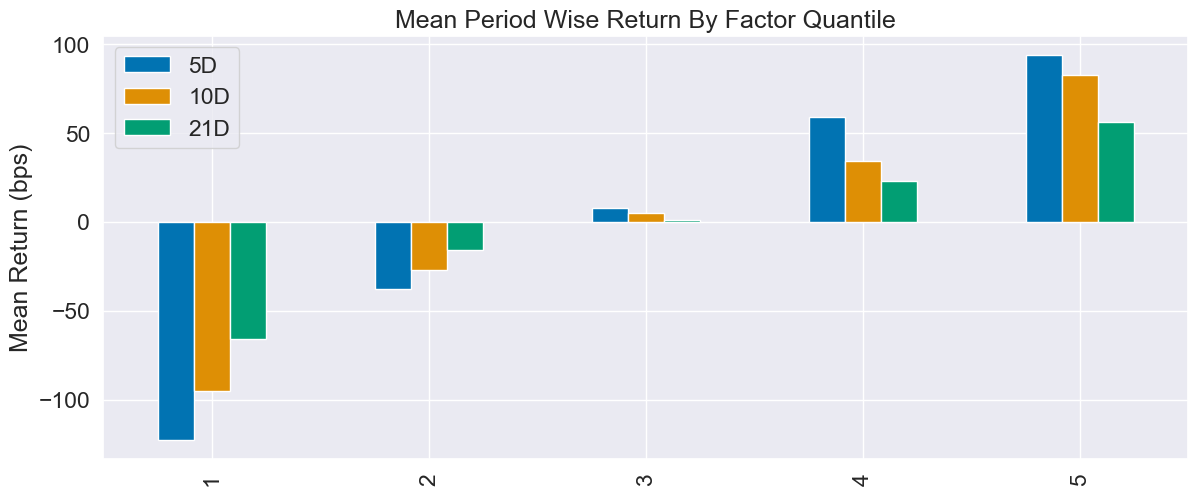

In [91]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.146069,0.179801,0.103370,0.039348,39257,20.049745
2,0.001359,0.188753,0.111012,0.034683,39103,19.971093
3,0.011287,0.198239,0.115164,0.034434,39121,19.980286
4,0.018064,0.206492,0.119020,0.034326,39103,19.971093
5,0.022405,0.244567,0.125191,0.034743,39214,20.027784


Returns Analysis


,5D,10D,21D
Ann. alpha,0.471,0.295,0.204
beta,0.052,0.114,0.120
Mean Period Wise Return Top Quantile (bps),93.882,82.457,56.306
Mean Period Wise Return Bottom Quantile (bps),-122.670,-94.966,-65.794
Mean Period Wise Spread (bps),216.552,177.289,122.462


<Figure size 640x480 with 0 Axes>

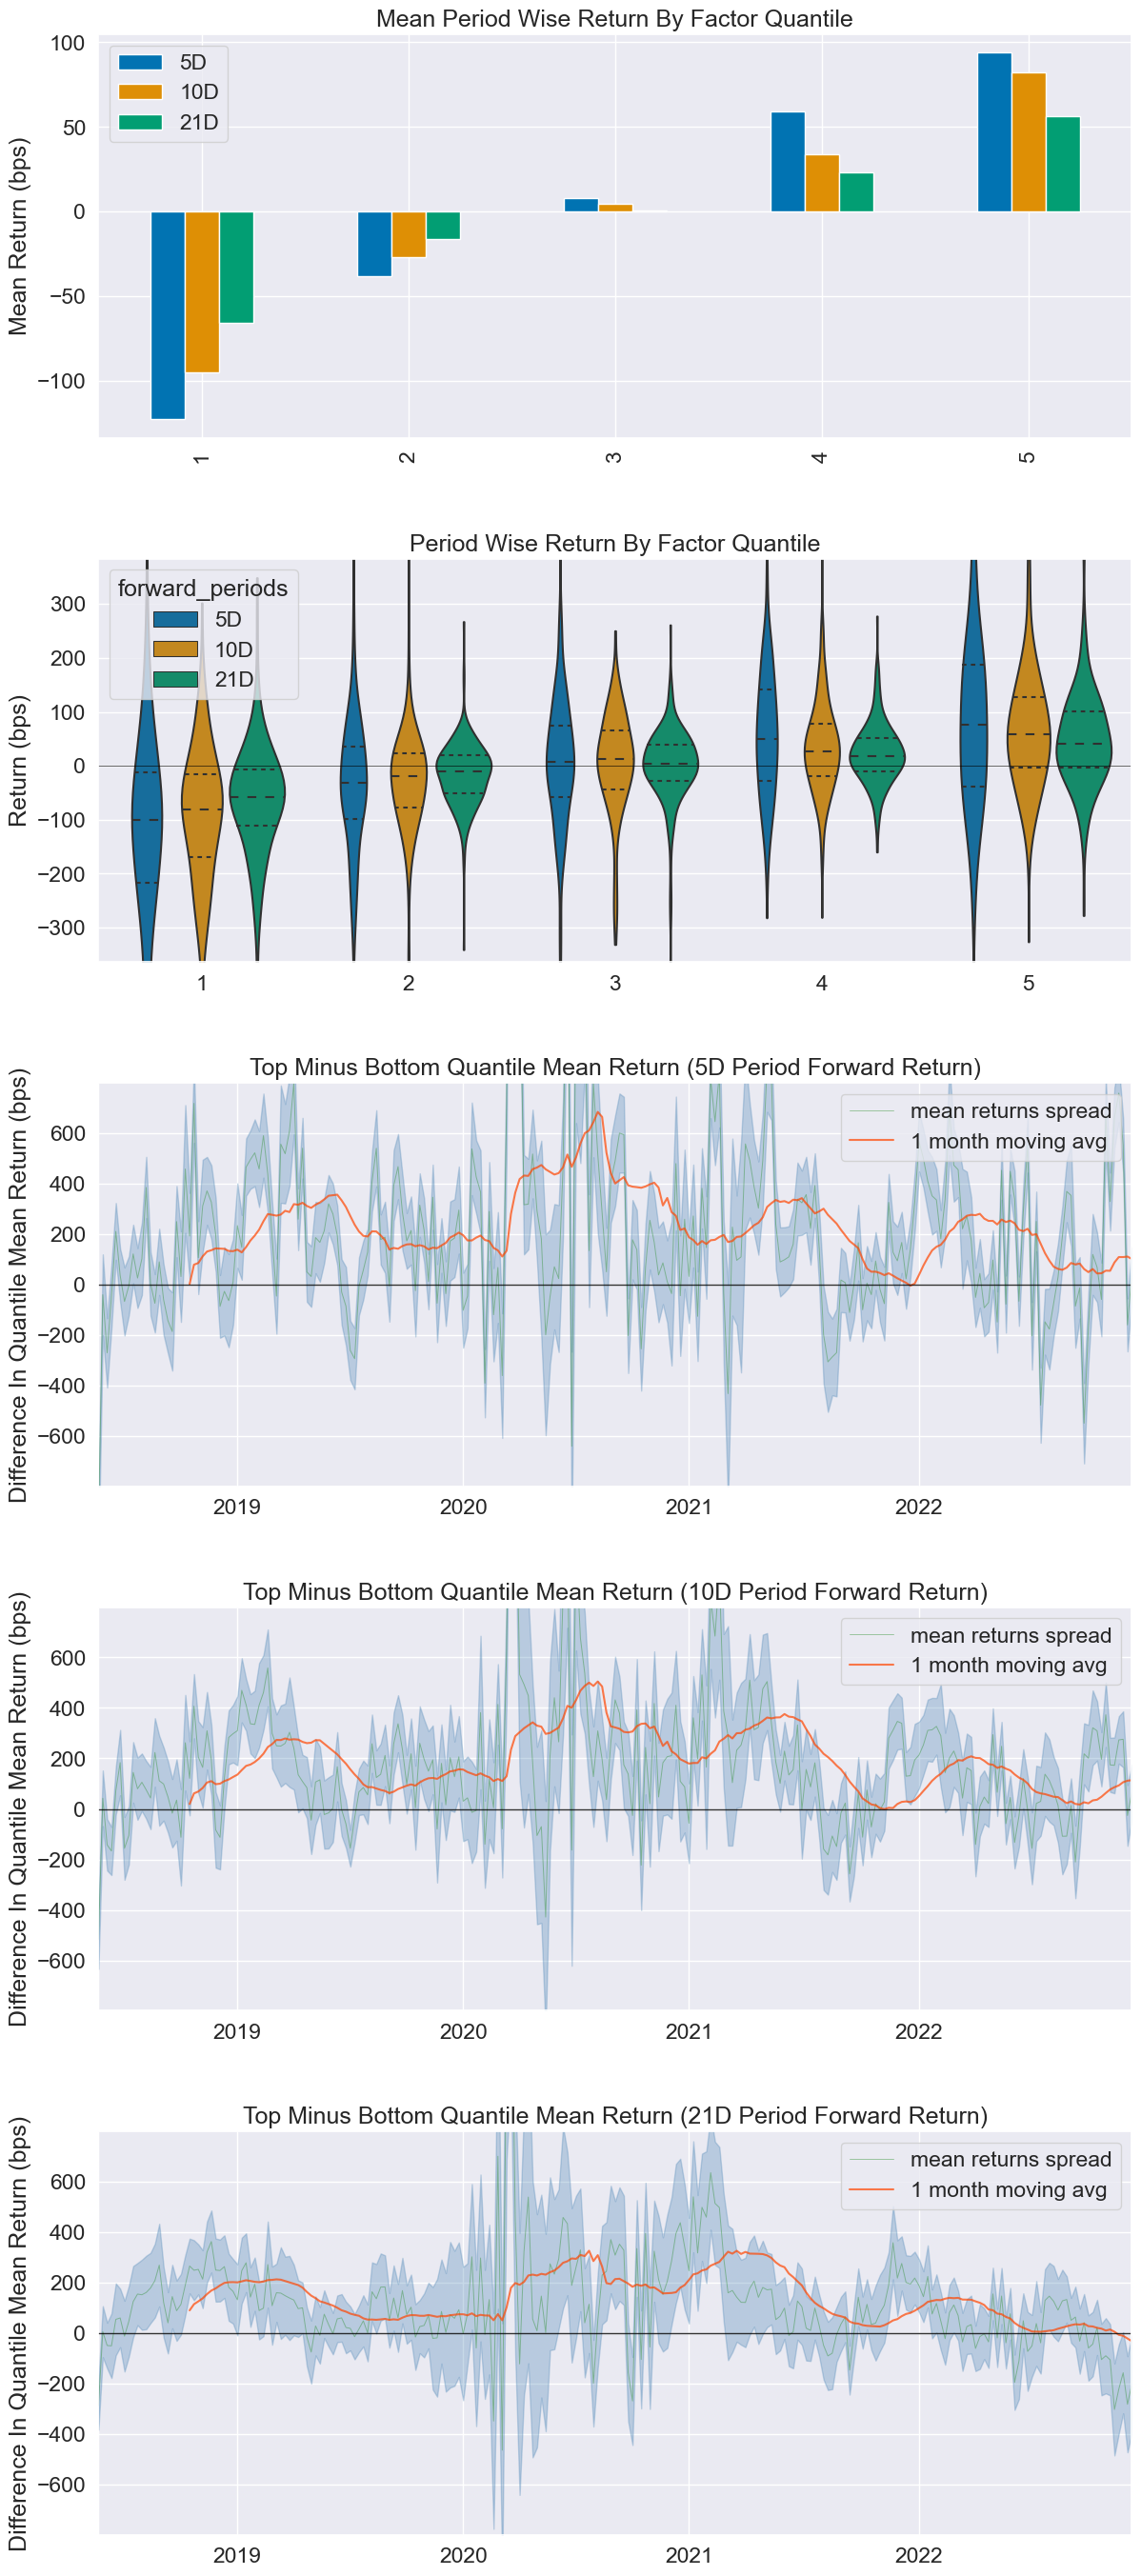

Information Analysis


,5D,10D,21D
IC Mean,0.069,0.075,0.078
IC Std.,0.100,0.093,0.089
Risk-Adjusted IC,0.685,0.808,0.876
t-stat(IC),10.595,12.497,13.549
p-value(IC),0.000,0.000,0.000
IC Skew,0.331,0.052,-0.225
IC Kurtosis,2.051,2.331,1.217


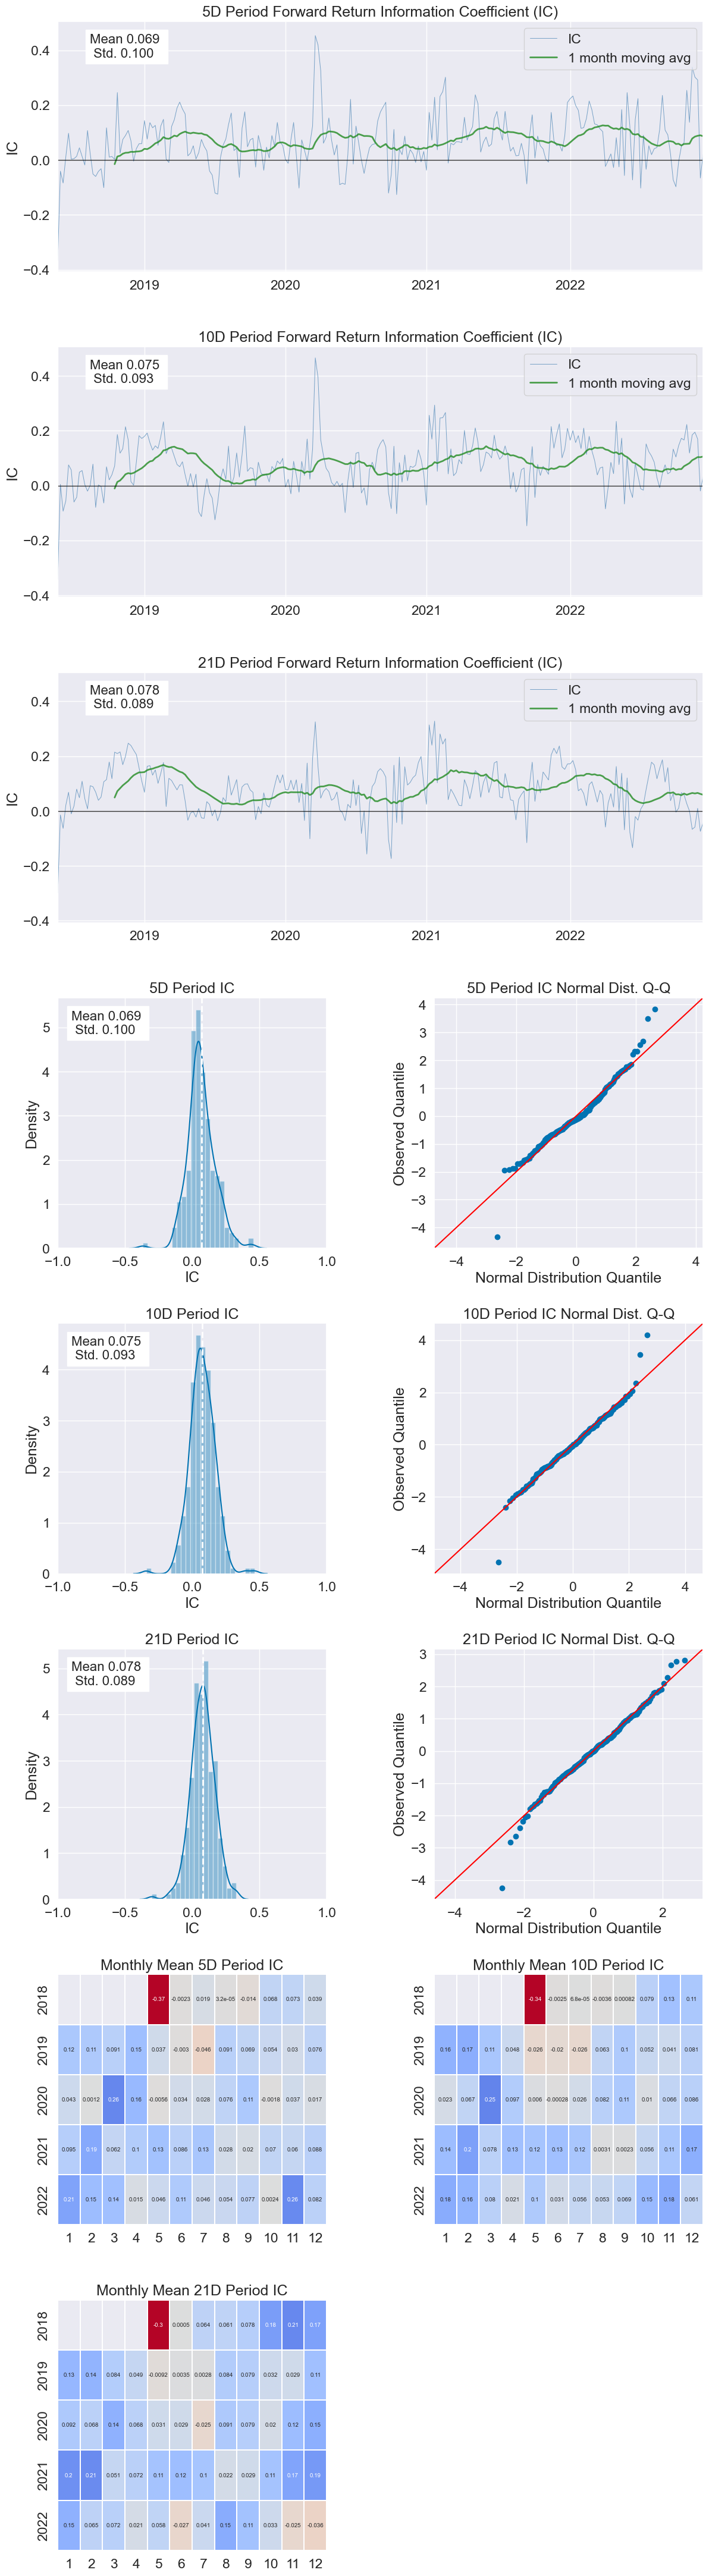

AttributeError: 'Index' object has no attribute 'get_values'

In [92]:
# Create the tear sheet
create_full_tear_sheet(factor_data=factor_data)[0]

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.349506,0.116892,0.062491,0.052813,34387,20.058916
2,-0.009095,0.124731,0.074604,0.022645,34226,19.965000
3,0.000340,0.132100,0.081139,0.021808,34243,19.974917
4,0.011042,0.140427,0.087978,0.021402,34225,19.964417
5,0.021491,0.306099,0.101534,0.023962,34349,20.036750


Returns Analysis


,5D,10D,21D
Ann. alpha,0.072,0.035,0.047
beta,0.164,0.083,0.010
Mean Period Wise Return Top Quantile (bps),53.997,31.525,26.095
Mean Period Wise Return Bottom Quantile (bps),-5.051,8.359,0.742
Mean Period Wise Spread (bps),59.049,22.885,25.220


<Figure size 640x480 with 0 Axes>

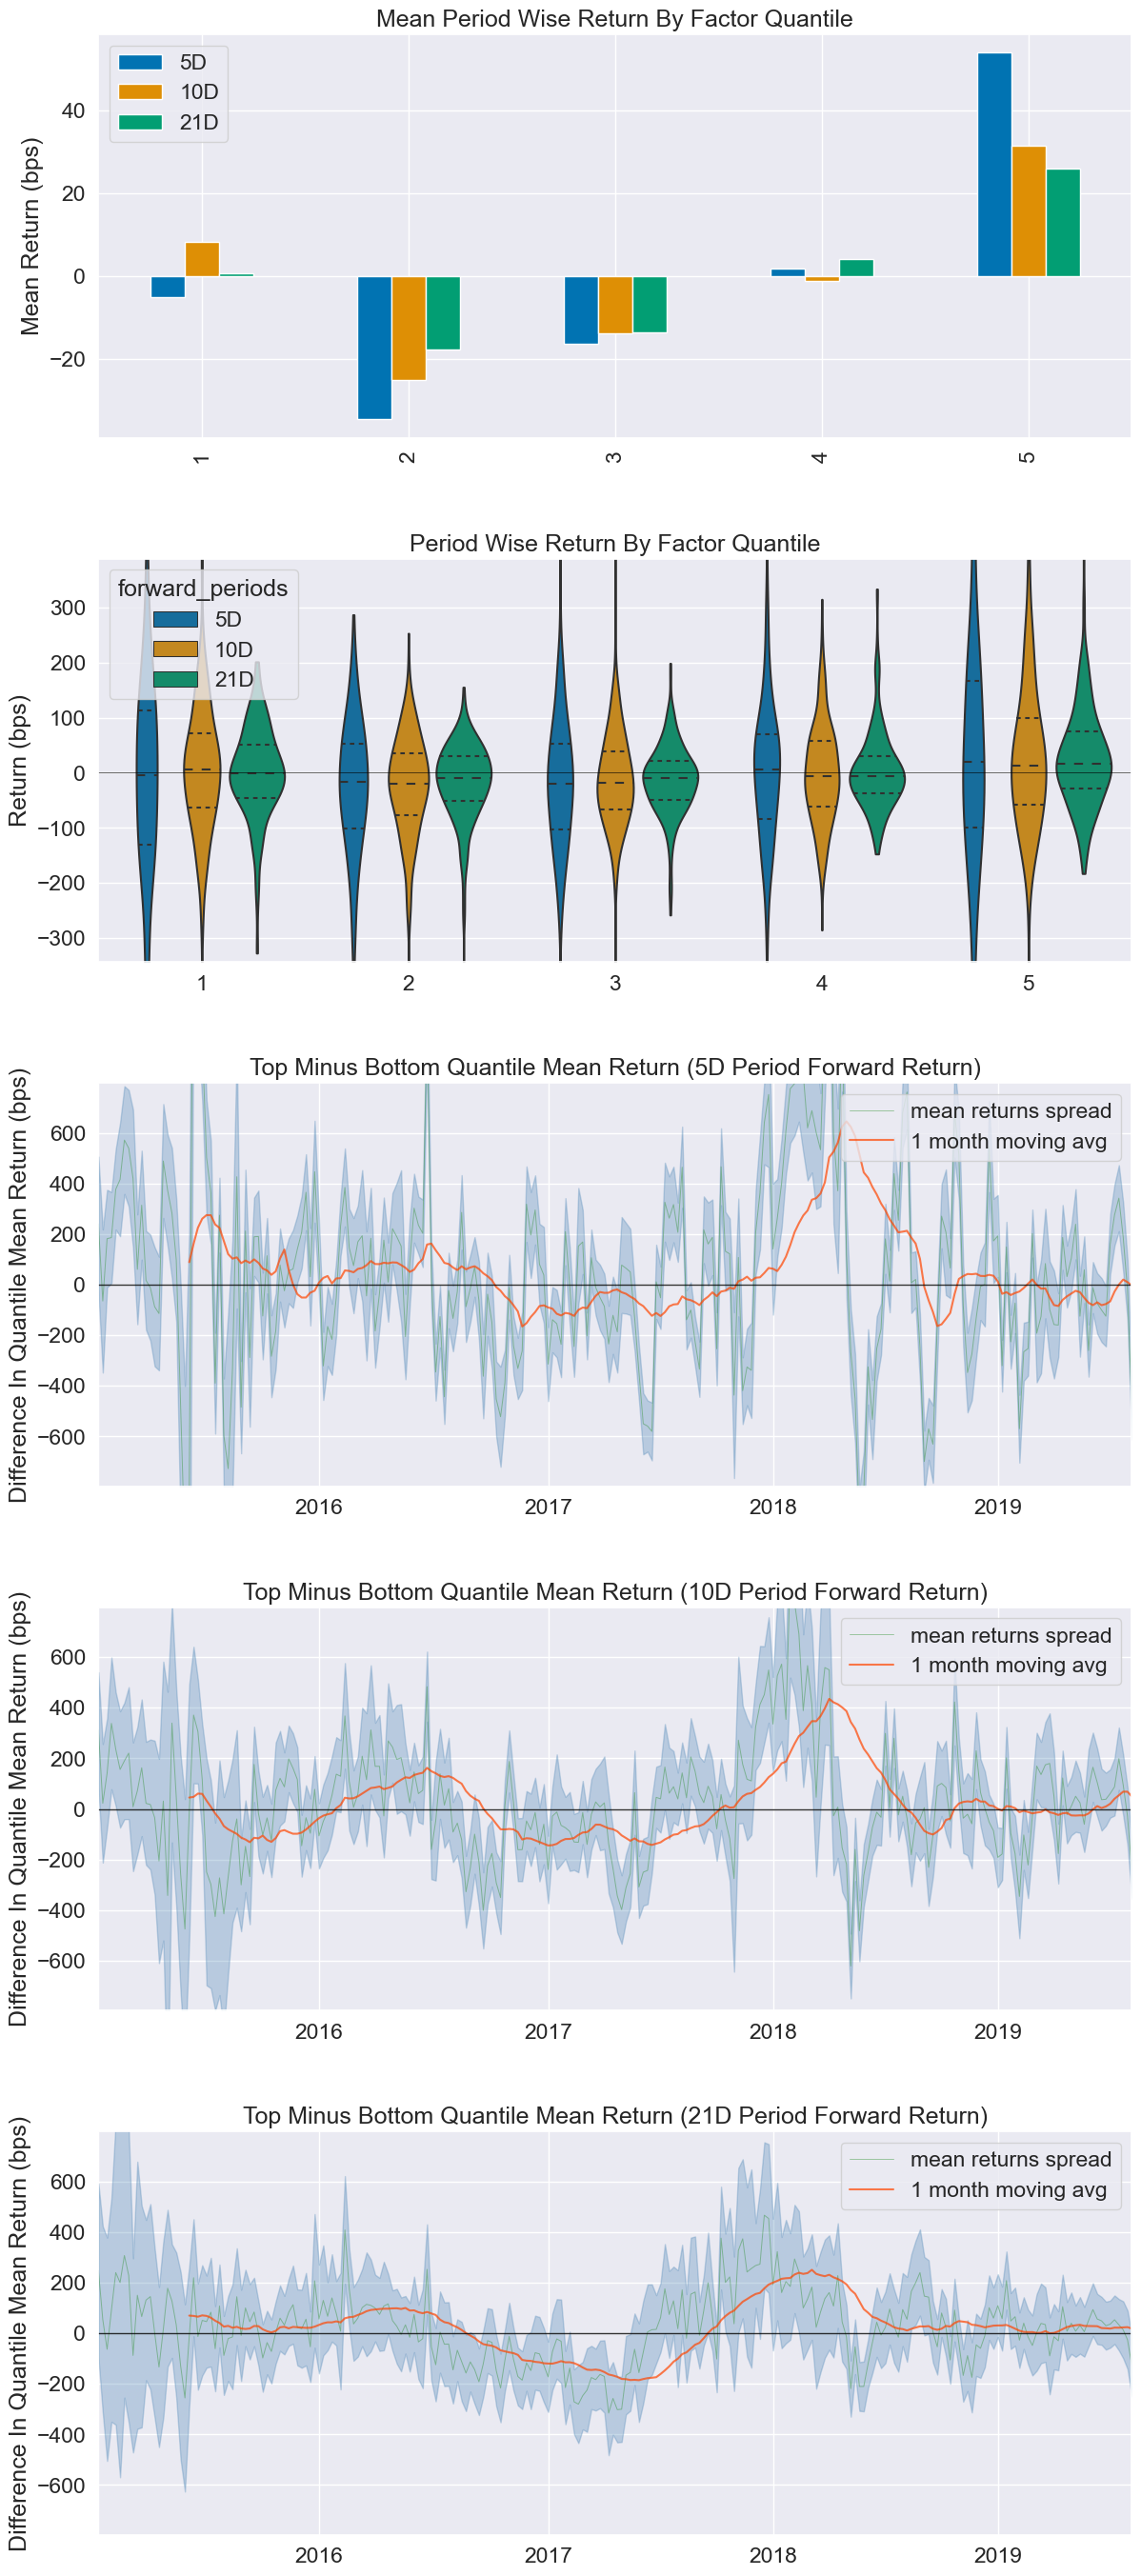

Information Analysis


,5D,10D,21D
IC Mean,-0.017,-0.024,-0.027
IC Std.,0.104,0.089,0.088
Risk-Adjusted IC,-0.162,-0.276,-0.309
t-stat(IC),-2.508,-4.271,-4.781
p-value(IC),0.013,0.000,0.000
IC Skew,-0.187,-0.496,-0.344
IC Kurtosis,0.464,0.251,-0.343


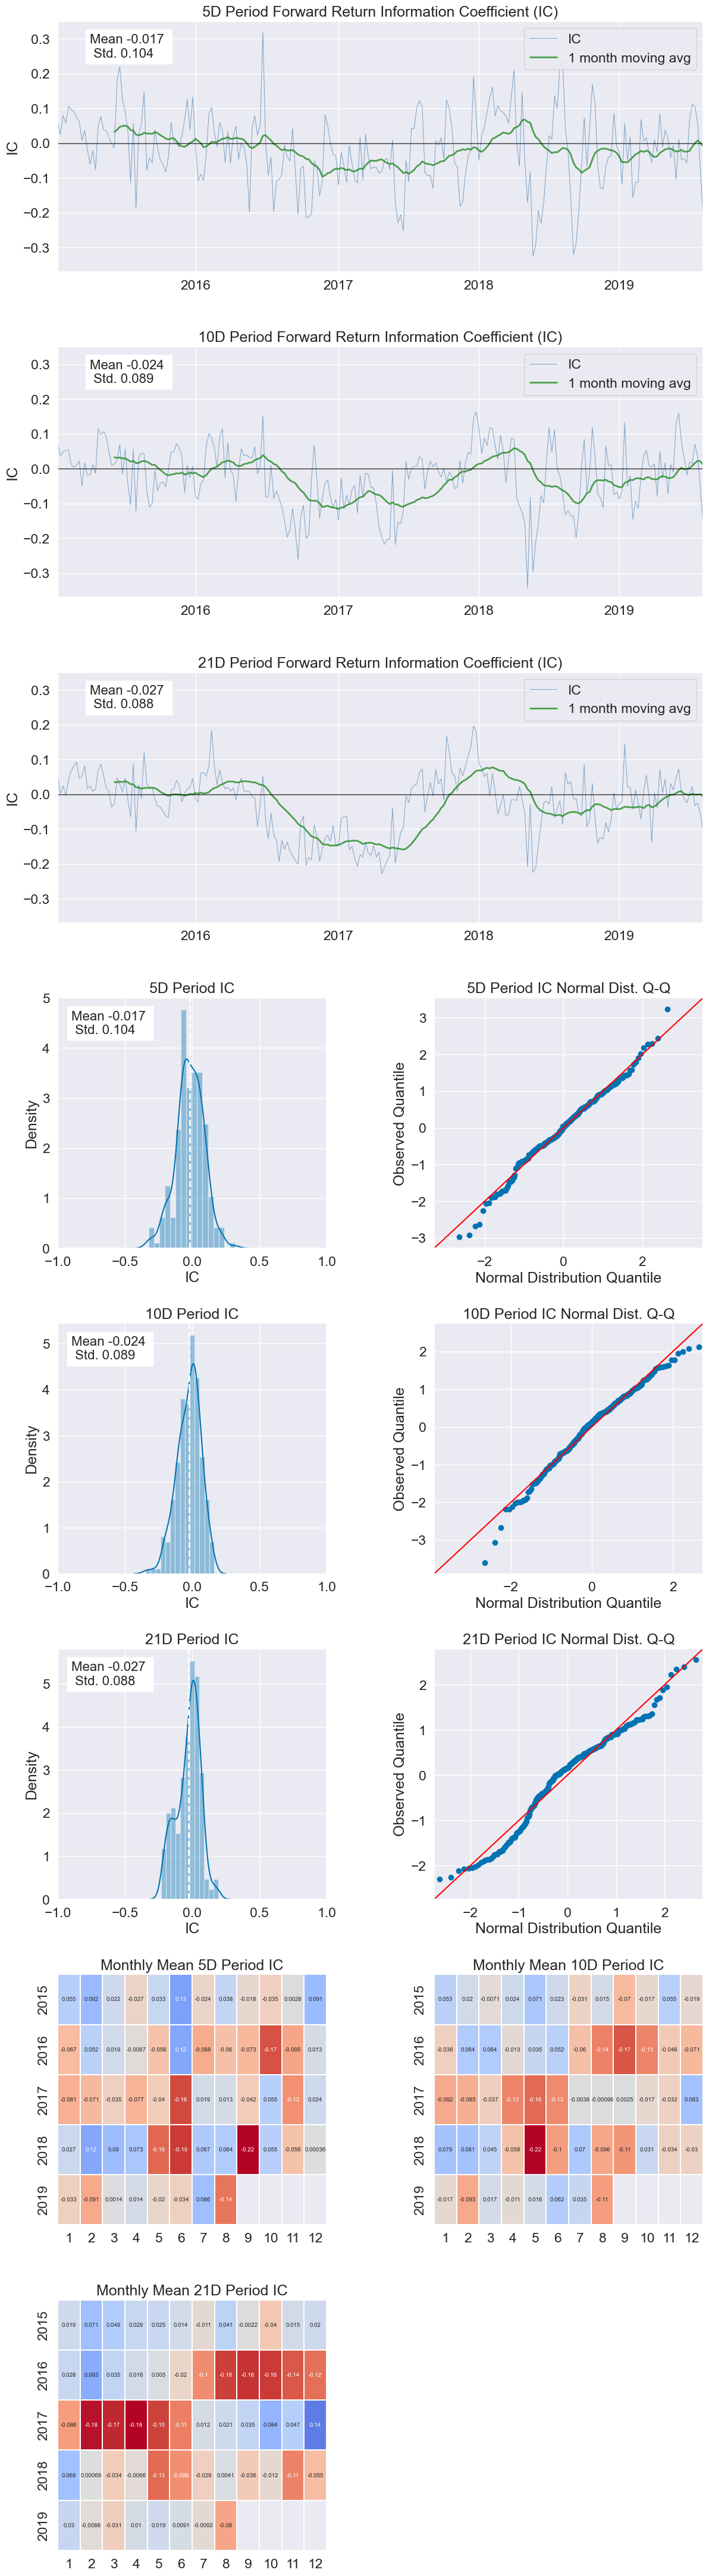

AttributeError: 'Index' object has no attribute 'get_values'

In [43]:
# Cumulative Returns
import alphalens as al
al.tears.create_full_tear_sheet(factor_data)